# Loading data using Xarray

We're going to try some basic operations with:

* monthly average (`Amon`) near-surface air temperatures (`tas`)
* from the latest version (`latest`) of the Met Office Hadley Centre's (`MOHC`) [Hadley Centre Global Environment Model version 3](https://www.metoffice.gov.uk/research/approach/modelling-systems/unified-model/climate-models/hadgem3) (`HadGEM3-GC31-LL`)
* running the pre-industrial control experiment (`piControl`) variant `r1i1p1f1`

We'll be:

* [Loading single or multiple NetCDF files](#Loading-single-or-multiple-NetCDF-files)
* [Selecting data for a coordinate or data variable](#Selecting-data-for-a-coordinate-or-data-variable)
* [Selecting data by value, range or condition](#Selecting-data-by-value,-range-or-condition)
* [Selecting data by position](#Selecting-data-by-position)
* [Aggregrating data by dimension](#Aggregrating-data-by-dimension)
* [Resampling time series data](#Resampling-time-series-data)
* [Grouping dimensions by value](#Grouping-dimensions-by-value)
* [Plotting line graphs](#Plotting-line-graphs)
* [Plotting colormeshes](#Plotting-colormeshes)
* [Plotting facet grids](#Plotting-facet-grids)
* Plotting on a projection - TODO
* Accessing raw data with .values - TODO

The data is available on JASMIN here:

In [1]:
data_directory = '/badc/cmip6/data/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piControl/r1i1p1f1/Amon/tas/gn/latest'

!ls {data_directory}

tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-194912.nc
tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_195001-204912.nc
tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_205001-214912.nc
tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_215001-224912.nc
tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_225001-234912.nc


In [2]:
!ncdump -h {data_directory}/tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_195001-204912.nc

netcdf tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_195001-204912 {
dimensions:
	time = UNLIMITED ; // (1200 currently)
	bnds = 2 ;
	lat = 144 ;
	lon = 192 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-01-01" ;
		time:calendar = "360_day" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
	double time_bnds(time, bnds) ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
	double lat_bnds(lat, bnds) ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
	double lon_bnds(lon, bnds) ;
	double height ;
		height:units = "m" ;
		height:axis = "Z" ;
		height:positive = "up" ;
		height:long_name = "height" ;
		height:standard_name = "height" ;
	float tas(time, lat, lon) ;
		tas:standard_name 

First, import the libraries we will be using:

In [3]:
from glob import glob

import matplotlib.pyplot as plt
import xarray as xr

# Set some plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## Loading single or multiple NetCDF files

We can either load a single NetCDF file:

In [4]:
dataset = xr.load_dataset(data_directory + '/tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_195001-204912.nc')

open multiple NetCDF files as one dataset by using wildcards:

In [6]:
dataset = xr.open_mfdataset(data_directory + '/*.nc')

or even pass a list of NetCDF files if we want to load more than one variable.

For example, if we wanted to load near-surface air temperature (`tas`) and precipitation flux (`pr`):

<span style="color:red">*Got `ValueError: cannot guess the engine, try passing one explicitly` the original way. It could have been because `open_mfdataset` was being given a list of lists. I've flattened them to one list in my method below - JH*</span> 

In [10]:
import itertools
paths = [glob(f'/badc/cmip6/data/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/piControl/r1i1p1f1/Amon/{variable}/gn/latest/*.nc') for variable in ['tas', 'pr']]
paths = list(itertools.chain(*paths))
dataset = xr.open_mfdataset(paths)

This will (lazily) load the data into an [`xr.DataArray` structure](https://xarray.pydata.org/en/stable/data-structures.html). Loading lazily means that the data will only be loaded into memory as and when calculcations absolutely need to be performed (for example, when plotting a graph). See [Triggering calculations manually](#Triggering-calculations-manually).

Looking at `dataset` from within the notebook, we get similar information to the `ncdump -h` command, however it will be formatted nicely with some interactive buttons to help browse the structure of the data:

In [11]:
dataset

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 6000)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2349-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 1.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1200, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1200, 192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  267840.0
    creation_date:          2019-06-20T13:03:20Z
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    variable_id:            pr
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/c1cbbfda-b0a8-4bc5-9090-9d53cb2c0200

We can also check the coordinates and data variables using the `dims` and `data_vars` properties of the dataset, and can access individual attributes by using the `attrs` property:

In [12]:
dataset.dims

Frozen(SortedKeysDict({'time': 6000, 'bnds': 2, 'lat': 144, 'lon': 192}))

In [13]:
dataset.data_vars

Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1200, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1200, 192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1200, 144, 192), meta=np.ndarray>

In [14]:
dataset.attrs['further_info_url']

'https://furtherinfo.es-doc.org/CMIP6.MOHC.HadGEM3-GC31-LL.piControl.none.r1i1p1f1'

## Selecting data for a coordinate or data variable

The recommended way to select data for a coordinate or data variable is to [use the dataset like a dictionary](https://xarray.pydata.org/en/stable/data-structures.html#dataset-contents):

In [15]:
air_temperature = dataset['tas']
precipitation = dataset['pr']

### Triggering calculations manually

You will find that xarray does not actually compute the result of a calculation until it's needed (for example, in a plot).

If you want to force the data to be loaded, or a calculation to be made straight away, then you can use `.compute()`, for example:

In [16]:
air_temperature

<xarray.DataArray 'tas' (time: 6000, lat: 144, lon: 192)>
dask.array<concatenate, shape=(6000, 144, 192), dtype=float32, chunksize=(1200, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 00:00:00 ... 2349-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-20T13:04:39Z altered by CMOR: Treated scalar dime...

This is telling you about the size and shape of the result, but not its value because it has not yet been calculated.

The actual calculation will be done using [Dask](https://dask.org/) (note the "15 Tasks, 5 Chunks"):

In [17]:
air_temperature.compute()

<xarray.DataArray 'tas' (time: 6000, lat: 144, lon: 192)>
array([[[250.32886, 250.32324, 250.32935, ..., 250.34937, 250.33301,
         250.32056],
        [251.0586 , 250.94751, 250.86621, ..., 251.32129, 251.23145,
         251.18994],
        [251.68872, 251.55005, 251.34009, ..., 252.21875, 252.01123,
         251.76636],
        ...,
        [235.06787, 235.12476, 235.22192, ..., 234.69995, 234.83398,
         234.93921],
        [233.54102, 233.62524, 233.67993, ..., 233.32544, 233.40308,
         233.4773 ],
        [231.41382, 231.42969, 231.40356, ..., 231.32178, 231.36523,
         231.35059]],

       [[235.42041, 235.44043, 235.44922, ..., 235.46582, 235.44946,
         235.43115],
        [236.75244, 236.69043, 236.62769, ..., 236.94019, 236.8938 ,
         236.81152],
        [237.34253, 237.24854, 237.1272 , ..., 237.73315, 237.59863,
         237.4458 ],
...
        [242.58374, 242.7544 , 242.95117, ..., 242.10327, 242.2522 ,
         242.45459],
        [241.95752, 242.0127 , 242.0586 , ..., 241.70459, 241.81274,
         241.88501],
        [241.06982, 241.09692, 241.09326, ..., 241.08228, 241.0752 ,
         241.07373]],

       [[255.11694, 255.10498, 255.11841, ..., 255.13794, 255.12451,
         255.12451],
        [255.86841, 255.77466, 255.67114, ..., 256.13965, 256.05762,
         255.97363],
        [256.39673, 256.21167, 256.08203, ..., 256.84888, 256.70703,
         256.54248],
        ...,
        [239.31738, 239.3352 , 239.35742, ..., 239.24683, 239.26514,
         239.27979],
        [239.31421, 239.29858, 239.31665, ..., 239.29224, 239.29468,
         239.29883],
        [239.52539, 239.50659, 239.51709, ..., 239.51123, 239.49268,
         239.50684]]], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-16 00:00:00 ... 2349-12-16 00:00:00
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
    height   float64 1.5
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-06-20T13:04:39Z altered by CMOR: Treated scalar dime...

## Selecting data by value, range or condition

### By value

To [select a value from a dimension](https://xarray.pydata.org/en/stable/indexing.html#indexing-with-dimension-names), we can use the `.sel()` method.

For example, to select the air temperatures (for all latitudes and longitudes) for January 2000:

In [18]:
temperature_january = air_temperature.sel(time='2000-01')
temperature_january.sizes

Frozen({'time': 1, 'lat': 144, 'lon': 192})

(Note: for simplicity we're just displaying the size of the resulting data)

When selecting by date, depending on the precision of the date we supply, more than one value may be returned.

For example, to select each of the monthly air temperatures (for all latitudes and longitudes) for 2000:

In [19]:
temperature_2000 = air_temperature.sel(time='2000')
temperature_2000.sizes

Frozen({'time': 12, 'lat': 144, 'lon': 192})

If an exact match to your filter conditions doesn't exist, you can use the `method='nearest'` argument to [find the closest matching point](https://xarray.pydata.org/en/stable/indexing.html#nearest-neighbor-lookups). This is especially useful when selecting locations:

In [20]:
bristol_temperature = air_temperature.sel(lat=51.4578, lon=-2.6017, method='nearest')
bristol_temperature.sizes

Frozen({'time': 6000})

### By range

It's possible to use the `slice(start, end[, step])` function to specify ranges:

In [21]:
temperature_decade = air_temperature.sel(time=slice("2000-01", "2009-12"))
temperature_decade.sizes

Frozen({'time': 120, 'lat': 144, 'lon': 192})

Bear in mind that unlike regular Python slicing, the range is inclusive of the `start` and `end` values supplied.

In [22]:
temperature_equator = air_temperature.sel(lat=slice(-10, 10))
temperature_equator.sizes

Frozen({'time': 6000, 'lat': 16, 'lon': 192})

### By condition

For more complex queries, it is often convenient to use boolean arrays, which you can give helpful names to.

For example, to select air temperatures for extreme latitudes it is winter in the northern hemisphere:

In [23]:
is_winter = air_temperature['time'].dt.season == 'DJF'
is_extreme_latitude = abs(air_temperature['lat']) > 60

temperature_winter_poles = air_temperature.isel(time=is_winter, lat=is_extreme_latitude)
temperature_winter_poles.sizes

Frozen({'time': 1500, 'lat': 48, 'lon': 192})

## Selecting data by position

Sometimes you will need to select data by position in the dataset. This can be done using the `.isel()` method, but it is generally better to use `.sel()` to select by value, unless you're selecting using a boolean array.

For example, to select the first data point in the time dimension:

In [24]:
first_temperature = air_temperature.isel(time=0)
first_temperature.sizes

Frozen({'lat': 144, 'lon': 192})

## Aggregrating data by dimension

You can [aggregate your data](https://xarray.pydata.org/en/stable/computation.html#aggregation) using the `.mean()`, `.max()`, `.min()`, `.median()`, `.std()`, `.sum()`, etc. methods.

For example, the mean temperature over all time:

In [25]:
average_temperature = air_temperature.mean(dim='time')
average_temperature.sizes

Frozen({'lat': 144, 'lon': 192})

or over every longitude as well:

In [26]:
average_temperature = air_temperature.mean(dim=['time', 'lon'])
average_temperature.sizes

Frozen({'lat': 144})

or over all the data:

In [27]:
average_temperature = air_temperature.mean()
average_temperature.sizes

Frozen({})

Recall that we can call `.compute()` to find out what this is:

In [28]:
average_temperature.compute()

<xarray.DataArray 'tas' ()>
array(277.46924, dtype=float32)
Coordinates:
    height   float64 1.5

## Resampling time series data

When working with time series data, you [can use `.resample()`](https://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations) which has the [same syntax as Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html), in combination with the aggregation functions.

For example, to calculate the annual mean, minimum and maximum temperatures for Bristol:

In [29]:
bristol_temperature = air_temperature.sel(lat=51.4578, lon=-2.6017, method="nearest")

annual_bristol_temperatures = (
    bristol_temperature
    .resample(time="1Y")
)

mean_annual_temperature = annual_bristol_temperatures.mean()
min_annual_temperature = annual_bristol_temperatures.min()
max_annual_temperature = annual_bristol_temperatures.max()

mean_annual_temperature.sizes

Frozen({'time': 500})

## Grouping dimensions by value

[Grouping data by value](https://xarray.pydata.org/en/stable/groupby.html) works similarly to resampling, again using a familiar Pandas-style syntax, except additional calendar functionality is available.

For example, to calcuate the mean temperature in Bristol for each season:

In [30]:
bristol_seasonal_temperature = (
    bristol_temperature
    .groupby("time.season")
    .mean()
    .reindex(season=["DJF", "MAM", "JJA", "SON"])  # Put the values in a useful order
)

bristol_seasonal_temperature.compute()

<xarray.DataArray 'tas' (season: 4)>
array([278.642  , 280.7515 , 288.65384, 285.46402], dtype=float32)
Coordinates:
  * season   (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
    lat      float64 51.88
    lon      float64 0.9375
    height   float64 1.5

## Plotting line graphs

TODO

Putting it all together:

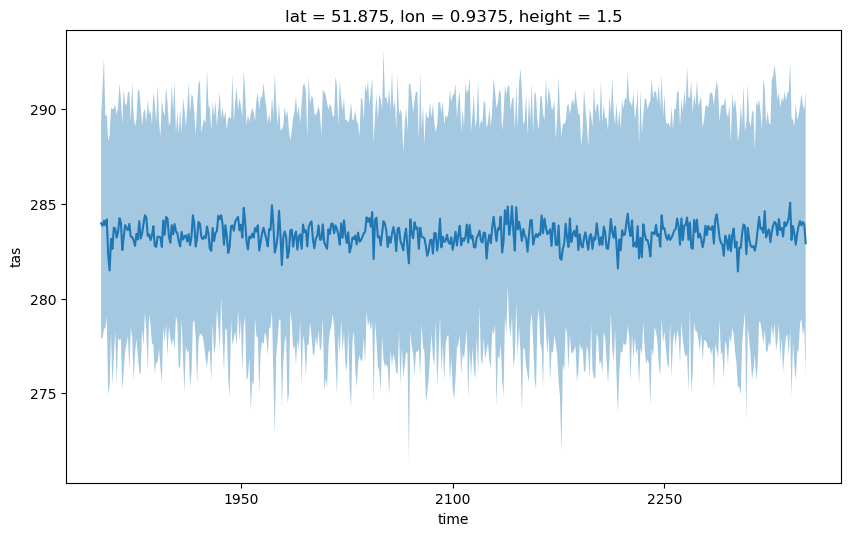

In [31]:
air_temperature = dataset['tas']

bristol_temperature = air_temperature.sel(lat=51.4578, lon=-2.6017, method="nearest")

mean_annual_temperature = bristol_temperature.resample(time="1Y").mean()
min_annual_temperature = bristol_temperature.resample(time="1Y").min()
max_annual_temperature = bristol_temperature.resample(time="1Y").max()

mean_annual_temperature.plot()

plt.fill_between(
    x=min_annual_temperature['time'].values,
    y1=min_annual_temperature.values,
    y2=max_annual_temperature.values,
    alpha=0.4,
)

## Plotting colormeshes

TODO

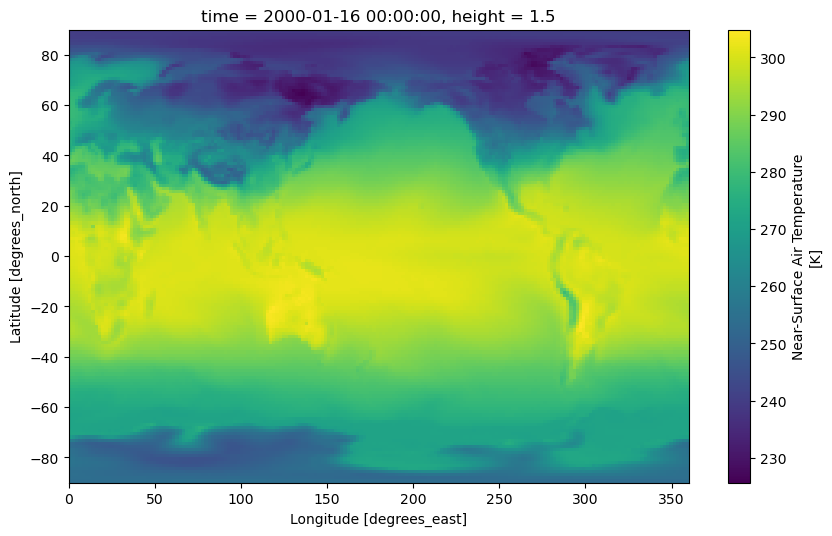

In [32]:
(
    dataset['tas']
    .sel(time="2000-01")
).plot()

## Plotting facet grids

TODO

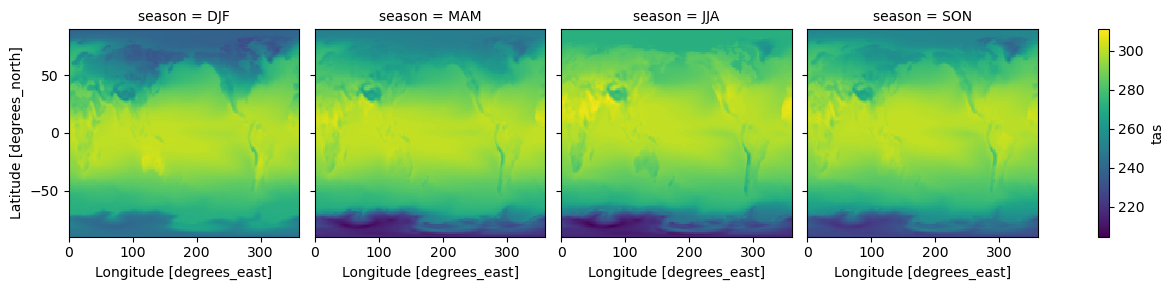

In [33]:
(
    dataset['tas']
    .groupby('time.season')
    .mean()
    .reindex(season=['DJF', 'MAM', 'JJA', 'SON'])  # Put the values in a useful order
).plot(col='season')

## Further reading

* [xarray documentation](https://xarray.pydata.org/en/stable/index.html)
* [pandas documentation](https://pandas.pydata.org/docs/)
* [Matpltlib documentation](https://matplotlib.org/stable/contents.html)
* [NumPy documentation](https://numpy.org/doc/stable/)
* Bristol [Advanced Computing Research Centre (ACRC) training](https://www.bristol.ac.uk/acrc/acrc-training/)

## Acknowledgements

By: [James Thomas](https://github.com/jatonline/)

Last updated: 22nd April 2021